In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import math
import copy
import spacy
import pathlib
from pathlib import Path


from funnel_transformer_conan import *
from data_loader import *

from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/funnel_experiment2')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
data_en = EnFrDataset(used_abridged_data=True, max_seq_length=100)

Reading the dataframe and storing untokenized pairs...


100%|██████████| 5000/5000 [00:00<00:00, 175829.36it/s]


Adding sentences to Langs amd geting data pairs...


100%|██████████| 5000/5000 [00:00<00:00, 6770.63it/s]


Creating tokenized pairs of english and french sentences...


100%|██████████| 5000/5000 [00:00<00:00, 12390.05it/s]


In [4]:
train_dataloader = DataLoader(data_en, batch_size=32, shuffle=False, num_workers=6)

In [14]:
from data_loader import *
from funnel_transformer_conan import *
# full_dataset_path = Path('data/en-fr.csv')
# abridged_dataset_path = Path('data/en-fr-abridged.csv')

# ds = pd.read_csv(abridged_dataset_path)
# english, french, pairs = read_lang('en', 'fr', abridged_dataset)

# src_vocab_size = 5000
# tgt_vocab_size = 5000
# d_model = 512
# num_heads = 8
# num_layers = 6
# d_ff = 2048
# max_seq_length = 100
# dropout = 0.1

src_vocab_size = data_en.get_src_lang_size()
tgt_vocab_size = data_en.get_tgt_lang_size()
d_model = 512
num_heads = 4
d_ff = 2014
max_seq_length = 100
encoder_blocks = 3
print(100%(2**encoder_blocks)!=0)
print(100/(2**encoder_blocks)==0)
assert((100%(2**(encoder_blocks-1))==0) or (100/(2**(encoder_blocks-1))!=0)),"dafaq"
decoder_blocks = 6
dropout = 0.1
# num_layers->encoder decoder block size
# num_layers = 6


f_transformer = Funnel_Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, decoder_blocks, encoder_blocks, d_ff, max_seq_length, dropout)
# transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

loss_criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(f_transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
batch_size = 64
f_transformer = f_transformer.to(device)
total_loss = 0.0
for epoch in range(1000):
    epoch_loss = []
    f_transformer.train()
    for it in train_dataloader:
        src_data, tgt_data = it
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)
        optimizer.zero_grad()
        output= f_transformer(src_data, tgt_data[:, :-1])
        loss = loss_criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss.append(total_loss)
    writer.add_scalar('training loss',
                    total_loss,
                        epoch)
    if epoch % 5 == 0:
        print(f"Epoch: {epoch+1}, Epoch Loss: {total_loss}")
    total_loss = 0.0
    

True
False
Epoch: 1, Epoch Loss: 233.56472009420395
Epoch: 6, Epoch Loss: 139.67332278192043
Epoch: 11, Epoch Loss: 106.96244916319847
Epoch: 16, Epoch Loss: 80.4711426422
Epoch: 21, Epoch Loss: 54.6243944875896
Epoch: 26, Epoch Loss: 33.624209789559245
Epoch: 31, Epoch Loss: 17.807973593473434
Epoch: 36, Epoch Loss: 8.594946513418108
Epoch: 41, Epoch Loss: 4.59889579215087
Epoch: 46, Epoch Loss: 2.714601469808258
Epoch: 51, Epoch Loss: 2.037526773463469
Epoch: 56, Epoch Loss: 1.4234865705657285
Epoch: 61, Epoch Loss: 1.1706255500030238
Epoch: 66, Epoch Loss: 0.9478688646340743
Epoch: 71, Epoch Loss: 0.8244956807611743
Epoch: 76, Epoch Loss: 0.74442016917601
Epoch: 81, Epoch Loss: 0.6621167350240285
Epoch: 86, Epoch Loss: 0.6378451323325862
Epoch: 91, Epoch Loss: 0.6273926338471938
Epoch: 96, Epoch Loss: 0.5862167064260575
Epoch: 101, Epoch Loss: 0.5119745690608397
Epoch: 106, Epoch Loss: 0.4501889005987323
Epoch: 111, Epoch Loss: 0.49350560705715907
Epoch: 116, Epoch Loss: 0.437026028

In [15]:
import numpy as np
torch.save(f_transformer.state_dict(), "model_ckpt/f_transformer.pth")
np.save("model_ckpt/epoch_loss_f_transformer.npy", np.array(epoch_loss))

In [41]:
df = pd.read_csv('model_ckpt/funnel_experiment.csv', sep=',', header=None)
df2 = pd.read_csv('model_ckpt/funnel_experiment2.csv', sep=',', header=None)

In [42]:
loss_record_transformer = df[2].values
loss_record_f_transformer = df2[2].values

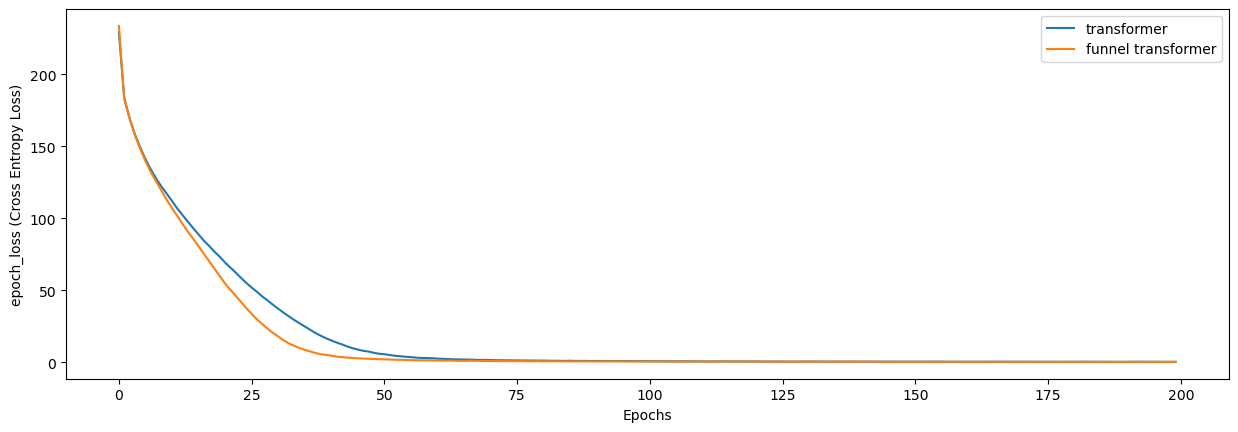

In [49]:
import matplotlib.pyplot as plt
plt.figure().set_figwidth(15)
plt.plot(loss_record_transformer[:200], label="transformer")
plt.plot(loss_record_f_transformer[:200], label="funnel transformer")
plt.xlabel("Epochs")
plt.ylabel("epoch_loss (Cross Entropy Loss)")
plt.legend()
plt.show()

In [25]:
src_vocab_size = data_en.get_src_lang_size()
tgt_vocab_size = data_en.get_tgt_lang_size()
d_model = 512
num_heads = 4
d_ff = 2014
max_seq_length = 100
encoder_blocks = 3

assert((100%(2**(encoder_blocks-1))==0) or (100/(2**(encoder_blocks-1))!=0)),"dafaq"
decoder_blocks = 6
dropout = 0.1
# num_layers->encoder decoder block size
# num_layers = 6


f_transformer_test = Funnel_Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, decoder_blocks, encoder_blocks, d_ff, max_seq_length, dropout)
f_transformer_test.load_state_dict(torch.load("model_ckpt/f_transformer.pth"))
f_transformer_test.to(device)

Funnel_Transformer(
  (encoder_embedding): Embedding(8327, 512)
  (decoder_embedding): Embedding(9693, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0): EncoderLayer_funnel(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2014, bias=True)
        (fc2): Linear(in_features=2014, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): EncoderLayer_funnel(
      (self_attn): MultiHead

In [40]:
inputs, outputs = next(iter(train_dataloader))
inputs = inputs.to(device)
outputs = outputs.to(device)

In [67]:
count = 0
for inputs, outputs in train_dataloader:
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    count = count + 1
    if count > 5:
        break 

In [68]:
test = f_transformer_test.decoder_embedding(outputs)
test = f_transformer_test.positional_encoding(test)
test.shape

torch.Size([32, 100, 512])

In [69]:
y_init = torch.LongTensor([CustomTokens.SOS.value])
print(y_init)
y_init = y_init.unsqueeze(0)
print(y_init)
y_init = y_init.cuda().view(1, 1)
print(y_init)

tensor([0])
tensor([[0]])
tensor([[0]], device='cuda:0')


In [70]:
outputs.shape

torch.Size([32, 100])

In [78]:
y_init = torch.LongTensor([CustomTokens.SOS.value]).unsqueeze(0).cuda().view(1, 1)
y_init = y_init.repeat(32,1)
print(y_init)

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0')


In [71]:
y_init = torch.LongTensor([CustomTokens.SOS.value]).unsqueeze(0).cuda().view(1, 1)
test = f_transformer_test.decoder_embedding(outputs)
print(test.shape)

torch.Size([32, 100, 512])


In [95]:
## the first token SOS
y_init = torch.LongTensor([CustomTokens.SOS.value]).unsqueeze(0).cuda().view(1, 1)
y_init = y_init.repeat(32,1)
# generate the necessary things
# the overall positional encoding of the output
toy_embeddings = f_transformer_test.decoder_embedding(outputs)
output_positional_encoding = f_transformer_test.positional_encoding(toy_embeddings)

output_encoding_for_inference = output_positional_encoding
# generate the mask for decoder
_,tgt_mask = f_transformer_test.generate_mask(inputs, outputs)

# generate the encoder output from the encoder
_, encoder_output = f_transformer_test(inputs, outputs)
for i in range(outputs.shape[1]-1):
    # get the embedding of the decoder input
    inf_emb = f_transformer_test.decoder_embedding(y_init)

    # added up with the positional encoding
    output_encoding_for_inference[:,:y_init.shape[1],:] = inf_emb + output_encoding_for_inference[:,:y_init.shape[1],:]

    # get the decoder output
    decoder_output = f_transformer_test.pass_through_decoder(output_encoding_for_inference, encoder_output, tgt_mask)

    decoder_output = f_transformer_test.fc(decoder_output)

    _, next_word = torch.max(
            decoder_output[:, y_init.shape[1] - 1 : y_init.shape[1],:], dim=2
        )
    print(next_word.shape)
    y_init = torch.cat([y_init, next_word.view(32,1)], dim=1)

print(y_init)

torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 9693])
torch.Size([32, 1])
torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 9693])
torch.Size([32, 1])
torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 9693])
torch.Size([32, 1])
torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 9693])
torch.Size([32, 1])
torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 9693])
torch.Size([32, 1])
torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 9693])
torch.Size([32, 1])
torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 9693])
torch.Size([32, 1])
torch.Size([32, 100, 512])
torch.Size([32, 100, 512])
torch.Size([32, 100, 9693])
torch.Size([32, 1, 969

In [100]:
y_init.shape

torch.Size([32, 100])

In [105]:
input_test = data_en.list_of_tokens_to_list_of_words(torch.squeeze(inputs), data_en.en_lang)
print(input_test)
output_test = data_en.list_of_tokens_to_list_of_words(torch.squeeze(y_init), data_en.fr_lang)
print(output_test)
output_real = data_en.list_of_tokens_to_list_of_words(torch.squeeze(outputs), data_en.fr_lang)
print(output_real)

[['SOS', 'observatories', 'launch', 'of', 'most', ',', 'the', 'first', 'space', 'telescope', 'to', 'be', 'entirely', 'designed', 'and', 'built', 'in', 'canada', '.', 'EOS'], ['SOS', 'evolution', 'of', 'images', 'image', 'of', 'lunar', 'crater', 'clavius', 'taken', 'at', 'the', 'mont', '-', 'mégantic', 'observatory', '.', 'EOS'], ['SOS', 'evolution', 'of', 'images', 'the', 'orion', 'nebula', 'as', 'seen', 'by', 'the', 'hubble', 'space', 'telescope', '.', 'EOS'], ['SOS', 'astronomes', 'the', 'next', 'generation', 'of', 'canadian', 'astronomers', '.', 'EOS'], ['SOS', 'observatories', 'planned', 'inauguration', 'of', 'the', 'atacama', 'large', 'millimeter', 'array', 'by', 'canada', ',', 'the', 'united', 'states', ',', 'europe', ',', 'japan', 'and', 'chile', '.', 'EOS'], ['SOS', 'in', 'the', 'future', ':', 'EOS'], ['SOS', 'observatories', 'planed', 'launch', 'of', 'the', 'james', 'webb', 'space', 'telescope', 'by', 'canada', ',', 'the', 'united', 'states', 'and', 'europe', '.', 'EOS'], ['SO

In [ ]:
def inference(model, src_data, tgt_data):
    model.eval()
    y_init = torch.LongTensor([CustomTokens.SOS.item.value]).unsqueeze(0).cuda().view(1, 1)

    ques_emb = model.emb_layer(inp_exp)
    q_emb_inp = ques_emb + inp_exp_pos
    _,enc_out = f_transformer_test(q_emb_inp)
    for i in range(out_seq_len - 1):
        ans_emb = model.emb_layer(y_init)
        a_emb_inp = ans_emb + out_pos_exp[:, : y_init.shape[1], :]
        dec_out = model.decoder(a_emb_inp, enc_out, None)
        _, next_word = torch.max(
            dec_out[0, y_init.shape[1] - 1 : y_init.shape[1]], dim=1
        )

        y_init = torch.cat([y_init, next_word.view(1, 1)], dim=1)
    return y_init, model